<a href="https://colab.research.google.com/github/asrianda/latAlgoritma/blob/main/misslasification/DTMissclafication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import queue
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

csv_dataset = pd.read_csv("species_classification.csv")
csv_dataset.describe()

,body temperature,\tskin cover,\tgives birth,\taquatic creature,\taerial creature,\thas legs,\thibernates,\tclass label
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.533333,1.666667,0.600000,1.000000,0.866667,0.266667,0.666667,1.533333
std,0.516398,1.496026,0.507093,0.755929,0.351866,0.457738,0.487950,1.457330
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.500000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,2.500000,1.000000,1.500000,1.000000,0.500000,1.000000,2.500000
max,1.000000,5.000000,1.000000,2.000000,1.000000,1.000000,1.000000,4.000000


### Keterangan Dataset

1.   body temperature
2.   kin cover;
3.   gives birth;
4.   aquatic creature;
5. aerial creature;
6. Thas legs;
7. hibernates.

`Class yang dimiliki
*   reptile;
*   fish;
*   amphibian;
*   bird.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


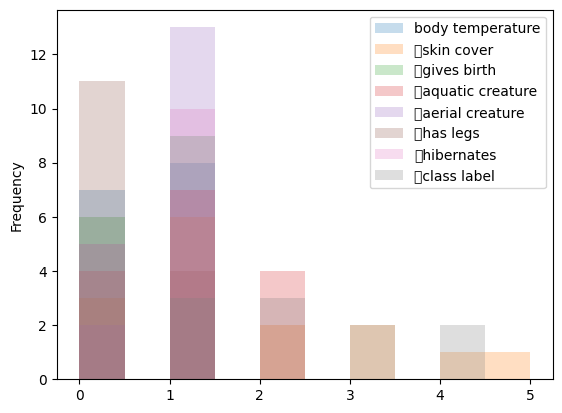

In [2]:
csv_dataset.plot.hist(alpha=0.25)
plt.show()

## Implementasi Misclassification Tree

In [3]:
class MisslaficationTreeNode:
  parent: None
  branch=None
  attr_index= None
  permitted_atributes= None
  permitted_entries= None
  children= None
  classes_dist_dict= None
  class_label= None

  def __init__(self, parent= None,
               attr_index= None,
               children= None,
               permitted_atributes= None,
               permitted_entries= None,
               classes_dist_dict= None,
               branch= None,
               class_type= None):
    self.class_label=class_type
    self.parent=parent
    self.attr_index=attr_index
    self.children=children
    self.permitted_atributes=permitted_atributes
    self.permitted_entries=permitted_entries
    self.classes_dist_dict=classes_dist_dict
    self.branch=branch


### Keterangan tentang Class


1.   parent = sebagai simpul induk
2.   branch = simpul cabang
3.   attr_index = untuk penyimpanan atribut index, jika itu class, menyimpan index baris class di db
4.   permitted_atributes = menyimpan list ke atributes_index yang dapat membuat attribut children
5. permitted_entries = menyimpan list dengan entries index, dapat digunakan membuat children
6. children = menyimpan list dengan node children
7. class_dist_dict = menyimpan list dengan mendistribusikan atribut node
8. class_type = untuk menampung dominan type_class jika berupa daun (node akhir)





In [4]:
def attr_distribution(x,y, distict_classes, attr_index, permitted_entries_indexes):
  branches_class_distribution={}
  branches= []
  for entry in permitted_entries_indexes:
    if x[entry][attr_index] not in branches:
      branches.append(x[entry][attr_index])
  for branch in branches:
    class_distribution_over_a_branch= {}
    for i in distict_classes:
      class_distribution_over_a_branch.update({i:0})
    total_of_single_branch=0
    for permitted_entry_index in permitted_entries_indexes:
      if branch== x[permitted_entry_index][attr_index]:
        total_of_single_branch +=1
        class_distribution_over_a_branch[y[permitted_entry_index]] = \
          class_distribution_over_a_branch[(y[permitted_entry_index])] + 1
    branches_class_distribution.update({branch: class_distribution_over_a_branch})
  return branches_class_distribution

### Mengembalikan nilai split dan list dengan attribute_distribution

In [5]:
def split_attr(x,y, distinc_classes, attr_index, permitted_entries_indexes):
  attr_dist= attr_distribution(x, y, distinc_classes, attr_index, permitted_entries_indexes)
  attr_split=0
  for dictionary in attr_dist.values():
    attr_split += (1- (max(dictionary.values())/ sum(dictionary.values()))) *(
            sum(dictionary.values()) / len(permitted_entries_indexes))
  return attr_split, attr_dist


Method **active_node** memecahkan permasalahan:


1.   permitted_entries_list = membuat list permitted_entries
2.   permitted_atribute_list = membuat list permitted_atribute_list
3. node_atribute = untuk mensplit permitted_atribute memilih salah sata yang memiliki split_index minimum



In [7]:

def activate_node(x,y, distinct_classes, class_column, node):
  entries= []
  atributes= []
  if node.parent is not None:
    for entry in node.parent.permitted_entries:
      if x[entry][node.parent.attr_index] == node.branch:
        entries.append(entry)
    for attr in node.parent.permitted_atributes:
      atributes.append(attr)
  else:
    for i in range(0, len(x)):
      entries.append(i)
    for i in range(0, len(x[0])):
      atributes.append(i)
  node.permitted_entries= entries
  attributes_split_index_dictionary= {}
  atributes_dist_dict = {}
  for atribute in atributes:
    split_index, attr_dist =split_attr(x,y, distinct_classes, atribute, entries)
    attributes_split_index_dictionary.update({atribute: split_index})
    atributes_dist_dict.update({atribute: attr_dist})
  attr_index=min(attributes_split_index_dictionary, key= attributes_split_index_dictionary.get)
  atributes.remove(attr_index)
  children= []
  node.attr_index = attr_index
  node.permitted_atributes = atributes
  node.classes_dist_dict = atributes_dist_dict.get(attr_index)
  for key, value in atributes_dist_dict.get(attr_index).items():
    child=MisslaficationTreeNode(parent=node,branch=key)
    child.classes_dist_dict=value
    if sum(value.values())==max(value) or len(atributes)==0:
      child.attr_index=class_column
      for key_1, value_1 in value.items():
        if value_1==max(value.values()):
          child.class_type=key
    children.append(child)
  node.children=children


Pertama sekali:
1.   Memanggil dataset dengan cara Random
2.   Membagi data latih dan data uji

In [23]:
class_column=7
db=csv_dataset.iloc[:,:].values.astype(np.int_)
np.random.shuffle(db)
y=db[:, class_column]
distinct_classes=np.unique(y)
x=np.delete(db, [class_column], axis=1)
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.1)
print(y_train)
print(y_test)

[4 1 4 0 0 0 2 1 2 3 3 0 2]
[0 1]


Root merupakan node pertama sekali yang diaktifkan. Kita menentukan atribut yang dapat dijalankan. berguna untuk menentukan node Root atribut. Untuk node Root semua entri data dan atribut dapat dibuat. Setelah, Root node dibuat, setalh itu menggunakan atrian entri data sebagai sisa pohon

In [27]:
root=MisslaficationTreeNode(parent=None)
nodes_to_activate=queue.Queue()
nodes_to_activate.put(root)
while not nodes_to_activate.empty():
  candidate=nodes_to_activate.get()
  activate_node(x_train, y_train, distinct_classes, class_column, candidate)
  for node in candidate.children:
    if node.attr_index is None:
      nodes_to_activate.put(node)

Sekarang kita telah mempunyai pohonnya, sekarang kita lihat
berapa banyak Node dan simpul daun yang dimilikinya, menggunakan algoritma BSF, kita akan menghitungnya

In [32]:
q=queue.Queue()
q.put(root)
count_nodes=1
counts_leafs=0
while not q.empty():
  candidate=q.get()
  count_nodes+=1
  if candidate.attr_index is class_column:
    counts_leafs+=1
  if candidate.children is not None:
    for node in candidate.children:
      q.put(node)
print("Pohon ini memiliki %s Node dan %s Daun." % (count_nodes, counts_leafs))

Pohon ini memiliki 70 Node dan 12 Daun.


Berikut ini, menggunakan data uji untuk mengukur akurasi pohon. Proses pembuatannya tergantung saat dataset di random, Kita membuat penentuan entri data baru, kasusnya pohon tidak dapat memberikan jawaban pasti

In [41]:
def decide(root, class_column, candidate):
  start=root
  while class_column is not start.attr_index:
    if start.attr_index==class_column:
      return start.class_type
    if candidate[start.attr_index]>= len(start.children):
      return -1
    else:
      start=start.children[candidate[start.attr_index]]
  return start.class_label

In [43]:
test_result=[]
for entry in x_test:
  test_result.append(decide(root,class_column, entry))
print(test_result)

[-1, -1]
